In [1]:
# All the required imports

import pandas as pd
import numpy as np
from torchvision import transforms, datasets, models
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch import optim
from skimage import io, transform
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, utils
import copy
import tqdm
import sys

from PIL import Image

%matplotlib inline 

In [2]:
# Exploring train.csv file
df = pd.read_csv('../input/train.csv')
df.head()

,Category,Id
0,41,zwnluz.jpg
1,6,ptsbsg.jpg
2,15,txhnvq.jpg
3,18,bulncb.jpg
4,18,tkvqyc.jpg


In [3]:
#Dataset class

class ImageDataset(Dataset):
    

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame['Id'][idx])         # getting path of image
        image = Image.open(img_name).convert('RGB')                                # reading image and converting to rgb if it is grayscale
        label = np.array(self.data_frame['Category'][idx])                         # reading label of the image
        
        if self.transform:            
            image = self.transform(image)                                          # applying transforms, if any
        
        sample = (image, label)        
        return sample

In [4]:
# Transforms to be applied to each image (you can add more transforms), resizing every image to 3 x 224 x 224 size and converting to Tensor
transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.ToTensor()
                                ])

trainset = ImageDataset(csv_file = '../input/train.csv', root_dir = '../input/data/data/', transform=transform)     #Training Dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0)                     #Train loader, can change the batch_size to your own choice

In [5]:
#Checking training sample size and label
for i in range(len(trainset)):
    sample = trainset[i]
    print(i, sample[0].size(), " | Label: ", sample[1])
    if i == 9:
        break

0 torch.Size([3, 224, 224])  | Label:  41
1 torch.Size([3, 224, 224])  | Label:  6
2 torch.Size([3, 224, 224])  | Label:  15
3 torch.Size([3, 224, 224])  | Label:  18
4 torch.Size([3, 224, 224])  | Label:  18
5 torch.Size([3, 224, 224])  | Label:  3
6 torch.Size([3, 224, 224])  | Label:  34
7 torch.Size([3, 224, 224])  | Label:  57
8 torch.Size([3, 224, 224])  | Label:  4
9 torch.Size([3, 224, 224])  | Label:  33


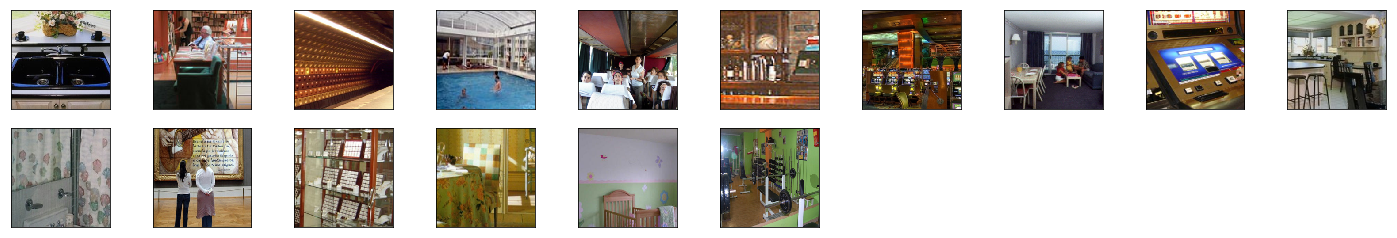

In [6]:
# Visualizing some sample data
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):                                             #Change the range according to your batch-size
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))

In [7]:
# check if CUDA / GPU is available, if unavaiable then turn it on from the right side panel under SETTINGS, also turn on the Internet
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
model = models.densenet161(pretrained=True)

device='cuda'
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 67)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30000,60000,90000], gamma=0.3)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:02<00:00, 44184360.10it/s]


In [9]:
child_counter = 0
for child in model.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

 child 0 is:
Sequential(
  (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(144, 192, kernel_

In [10]:
epochs = 8
itr = 1
p_itr = 5000
total_loss, score = 0,0
val_score = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
best_score = 0.0
loss_list = []
score_list = []


for epoch in range(epochs):
    model.train()
    for samples, labels in trainloader:
        samples, labels = samples.to(device), labels.to(device)    
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()

In [11]:
# Reading sample_submission file to get the test image names
submission = pd.read_csv('../input/sample_sub.csv')
submission.head()

,Category,Id
0,0,fysglz.jpg
1,0,dyiwdi.jpg
2,0,blyymx.jpg
3,0,xkyygh.jpg
4,0,efobnp.jpg


In [12]:
#Loading test data to make predictions
testset = ImageDataset(csv_file = '../input/sample_sub.csv', root_dir = '../input/data/data/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=0)


In [13]:
predictions=[]

In [14]:
model.eval()
# iterate over test data to make predictions
for images, labels in testloader:
    # move tensors to GPU if CUDA is available
    
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(images)
    _, pred = torch.max(output, 1)
    for i in range(len(pred)):
        predictions.append(int(pred[i]))
        

submission['Category'] = predictions             #Attaching predictions to submission file


In [15]:
#saving submission file
submission.to_csv('submission.csv', index=False, encoding='utf-8')

In [16]:
import os
os.environ['KAGGLE_USERNAME']='smiraldr'
os.environ['KAGGLE_KEY']='af95878e7e56a523ae5757c5ebdb85c3'

In [17]:
!pip install kaggle --upgrade

     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 81kB 16.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.4-cp36-none-any.whl size=65139 sha256=1ca3a0f2f0d3211ddf38bcf6a166c08a0d8ce066bd00f73ff1e52a106205721d
  Stored in directory: /tmp/.cache/pip/wheels/87/ea/09/173986e395d051411b9d547a69fe96cdc26208cb1bcc3e5567
  Created wheel for python-slugify: filename=python_slugify-3.0.2-py2.py3-none-any.whl size=4725 sha256=63fec9eb1a32dee0b987365533c8d1516fdd9a72e088046639354d3f9fdba736
  Stored in directory: /tmp/.cache/pip/wheels/16/7f/c3/6b0582283ad589d68a306da924a78c74546e010d8106b9b3a9
Successfully built kaggle python-slugify


In [18]:
!kaggle competitions submit -c qstp-deep-learning-2019 -f submission.csv -m "densenet161 0.005 unnormalized"

100%|██████████████████████████████████████| 63.0k/63.0k [00:06<00:00, 10.5kB/s]
Successfully submitted to QSTP - Deep Learning 2019